In [1]:
library(tidyverse)
library(lubridate)
library(ranger)

── Attaching packages ─────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [2]:
cabs.df <- read.csv('week2.csv') #, nrow=1000000)
head(cabs.df)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,2016-01-08T21:29:06Z,2016-01-08T21:42:15Z,2,1.83,-74.00793,40.74529,1,N,-73.98163,40.74050,1,10.0,0.5,0.5,1.50,0,0.3,12.80
2,2,2016-01-08T21:51:37Z,2016-01-08T22:11:39Z,1,3.18,-73.99075,40.73629,1,N,-73.96956,40.76864,1,14.5,0.5,0.5,3.16,0,0.3,18.96
3,2,2016-01-08T22:19:28Z,2016-01-08T22:27:23Z,1,1.17,-73.98230,40.77226,1,N,-73.98903,40.75946,2,7.0,0.5,0.5,0.00,0,0.3,8.30
4,2,2016-01-08T22:31:32Z,2016-01-08T22:42:51Z,1,5.27,-73.99078,40.76111,1,N,-73.95516,40.81983,1,16.5,0.5,0.5,2.00,0,0.3,19.80
5,2,2016-01-09T00:35:25Z,2016-01-09T00:40:30Z,1,1.14,-74.00389,40.75186,1,N,-74.00005,40.74311,2,6.0,0.5,0.5,0.00,0,0.3,7.30
6,2,2016-01-09T00:48:28Z,2016-01-09T00:55:14Z,1,1.70,-73.99881,40.74239,1,N,-73.98521,40.76309,1,7.5,0.5,0.5,1.76,0,0.3,10.56


In [3]:
# create day-of-week and hour-of-day cols
cabs_time.df <- cabs.df %>%
    mutate(pickup_datetime = ymd_hms(tpep_pickup_datetime),
           pickup_wday = wday(pickup_datetime),
           pickup_hour = hour(pickup_datetime)) %>%
    select(c(pickup_wday, 
             pickup_hour,
             pickup_longitude,
             pickup_latitude,
             payment_type,
             fare_amount))
head(cabs_time.df)

,pickup_wday,pickup_hour,pickup_longitude,pickup_latitude,payment_type,fare_amount
,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>
1,6,21,-74.00793,40.74529,1,10.0
2,6,21,-73.99075,40.73629,1,14.5
3,6,22,-73.98230,40.77226,2,7.0
4,6,22,-73.99078,40.76111,1,16.5
5,7,0,-74.00389,40.75186,2,6.0
6,7,0,-73.99881,40.74239,1,7.5


In [4]:
nrow(cabs_time.df)

# drop trips not paid for by credit card e.g. payment_type!=1
cabs_time_credit.df <- cabs_time.df %>%
    filter(payment_type == 1,
           fare_amount > 5) %>%
    select(-c(payment_type))
nrow(cabs_time_credit.df)

# take 20% subsample
cabs_rf.df <- cabs_time_credit.df %>%
    sample_frac(0.2)
nrow(cabs_rf.df)
names(cabs_rf.df)

[1] 2651287

[1] 1567865

[1] 313573

[1] "pickup_wday"      "pickup_hour"      "pickup_longitude" "pickup_latitude" 
[5] "fare_amount"

In [5]:
rf <- ranger(fare_amount ~ ., data=cabs_rf.df, importance='impurity')
print(rf)

Growing trees.. Progress: 29%. Estimated remaining time: 1 minute, 15 seconds.
Growing trees.. Progress: 58%. Estimated remaining time: 44 seconds.
Growing trees.. Progress: 89%. Estimated remaining time: 11 seconds.
Ranger result

Call:
 ranger(fare_amount ~ ., data = cabs_rf.df, importance = "impurity") 

Type:                             Regression 
Number of trees:                  500 
Sample size:                      313573 
Number of independent variables:  4 
Mtry:                             2 
Target node size:                 5 
Variable importance mode:         impurity 
Splitrule:                        variance 
OOB prediction error (MSE):       81.43434 
R squared (OOB):                  0.3494811 


In [6]:
sort(rf$variable.importance)

pickup_wday      pickup_hour  pickup_latitude pickup_longitude 
         1375490          1767586         12102032         16917789

It seems that the latitude and longitude were indeed the most important variables used for the random forest creation. Pickup hour and day of week were much weaker predictors, by more than a factor of 10.

In [7]:
# prep for plotting
library(ggplot2)
library(ggmap)
library(viridis)

# use only those observations with locations which are actually in NYC
cabs_data <- cabs_rf.df %>%
    filter(pickup_longitude < -60, 
           pickup_latitude > 30) 

# set width / exclude outliers from the map
width = 3
mean_lon = mean(cabs_data$pickup_longitude)
sd_lon = sd(cabs_data$pickup_longitude)
min_lon = mean_lon - (width * sd_lon)
max_lon = mean_lon + (width * sd_lon)
mean_lat = mean(cabs_data$pickup_latitude)
sd_lat = sd(cabs_data$pickup_latitude)
min_lat = mean_lat - (width * sd_lat)
max_lat = mean_lat + (width * sd_lat)

map_data <- cabs_data %>%
    filter(between(pickup_longitude, min_lon, max_lon),
           between(pickup_latitude, min_lat, max_lat))

pred.rf <- predict(rf, data=map_data)

Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.

Please cite ggmap if you use it! See citation("ggmap") for details.

Loading required package: viridisLite



Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.



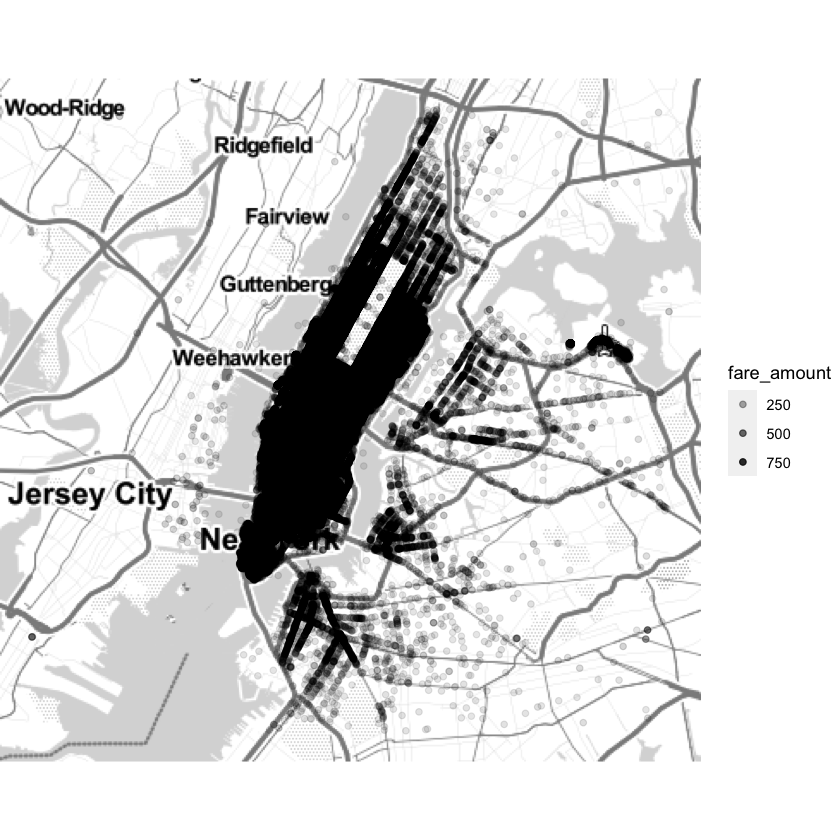

In [8]:
# plot fare amounts
qmplot(pickup_longitude, pickup_latitude, 
       alpha=fare_amount,
       zoom=11, data=map_data, maptype='toner-lite')